In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import os

import pickle
from pickle import load

import numpy as np
import tensorflow as tf

from skimage.transform import resize

from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def mostrar_img_blue(img, titulo = ''):
  plt.axis("off")
  plt.suptitle(titulo)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
def mostrar_img(img, titulo = ''):
  plt.axis("off")
  plt.suptitle(titulo)
  plt.imshow(img)
  plt.show()

In [ ]:
def salvar_modelo_treino(caminho, arquivo):
  pickle_data = open(caminho, 'wb')
  pickle.dump(arquivo, pickle_data)
  pickle_data.close()

In [ ]:
def carregar_modelo(caminho):
  modelo = load(open(caminho, 'rb'))
  return modelo

In [ ]:
def carregar_imagens_rotulos(caminho, pastas, tamanho_imagem):
  imagens = []
  rotulos = []

  for rotulo, pasta in enumerate(pastas):
    pasta_imagem = caminho + '/' + pasta
    nome_imagens = os.listdir(pasta_imagem)

    for nome_imagem in nome_imagens:
      caminho_imagem = pasta_imagem + '/' + nome_imagem

      imagem = cv2.imread(caminho_imagem)
      imagem = np.array(imagem, dtype=np.uint8)
      imagem_normalizada = cv2.resize(imagem, tamanho_imagem)

      imagens.append(imagem_normalizada)
      rotulos.append(rotulo)

  imagens = np.array(imagens)
  rotulos = np.array(rotulos)

  return imagens, rotulos

In [ ]:
def treino_split(imagens, rotulos):
  X_treino, X_teste, y_treino, y_teste = train_test_split(imagens, rotulos, test_size=0.2, random_state=42)

  X_treino = X_treino.astype('float32') / 255.0
  X_teste = X_teste.astype('float32') / 255.0

  return X_treino, X_teste, y_treino, y_teste

In [ ]:
def criar_classificador_densenet(densenet, num_classes):
  classificador = Sequential()
  classificador.add(densenet)
  classificador.add(GlobalAveragePooling2D())
  classificador.add(Dense(128, activation='relu'))
  classificador.add(Dense(num_classes, activation='softmax'))

  return classificador

In [ ]:
def usar_classificador_densenet(imagens, rotulos, num_classes, taxa_aprendizado = 0.0001):
  shape = imagens[0].shape

  densenet = DenseNet121(weights=None, include_top=False, input_shape=shape)
  X_treino, X_teste, y_treino, y_teste = treino_split(imagens, rotulos)

  lb = LabelBinarizer()
  y_treino = lb.fit_transform(y_treino)
  y_teste = lb.transform(y_teste)

  classificador_base = criar_classificador_densenet(densenet, num_classes)
  classificador_gradiente = criar_classificador_densenet(densenet, num_classes)
  classificador_adam = criar_classificador_densenet(densenet, num_classes)

  tipo_de_perda = 'binary_crossentropy'

  classificador_base.compile(optimizer='adam', loss=tipo_de_perda, metrics=['accuracy'])
  classificador_gradiente.compile(optimizer=SGD(learning_rate=taxa_aprendizado), loss=tipo_de_perda, metrics=['accuracy'])
  classificador_adam.compile(optimizer=Adam(learning_rate=taxa_aprendizado), loss=tipo_de_perda, metrics=['accuracy'])

  print(X_treino.shape)
  print(y_treino.shape)

  print("Classificador Base:\n")
  classificador_base.summary()

  print("\nClassificador Gradiente:\n")
  classificador_gradiente.summary()

  print("\nClassificador Adam:\n")
  classificador_adam.summary()

  return classificador_base, classificador_gradiente, classificador_adam, X_treino, X_teste, y_treino, y_teste

In [ ]:
def gerar_grafico(plots, titulo, valor_x, valor_y, legendas):
  cores = ['b', 'r', 'g', 'w', 'k', 'w', 'm', 'c']
  index = 0

  for plot in plots:
    plt.plot(plot, color=cores[index])
    index += 1

  plt.title(titulo)
  plt.xlabel(valor_x)
  plt.ylabel(valor_y)
  plt.legend(legendas, loc='upper left')
  plt.show()

In [ ]:
def mostrar_resultado_modelo(titulo, acuracia_treino, epocas_treino, acuracia_perda, acuracia_epocas):
  print("----------------------------RESULTADO-MODELOS----------------------------\n")

  print(f"--{titulo}--\n")

  acuracias = [f"{acuracia * 100:.2f}%" for acuracia in acuracia_treino]
  print(f"Acurácias durante o treinamento:\n{acuracias}\n")

  perdas = [f"{perda:.2f}" for perda in acuracia_perda]
  print(f"Perdas durante o treinamento:\n{perdas}\n")

  print()
  gerar_grafico([acuracia_treino, epocas_treino], "Acurácia", "Época", "Acurácia", ["Treinamento", "Validação"])
  print()
  gerar_grafico([acuracia_perda, acuracia_epocas], "Perda", "Época", "Perda", ["Treinamento", "Validação"])

In [ ]:
def treinar_modelo(classificador, X_treino, X_teste, y_treino, y_teste, epocas = 10, tamanho_batches = 32):
  modelo = classificador.fit(X_treino, y_treino, validation_data=(X_teste, y_teste), epochs=epocas, batch_size=tamanho_batches)

  return modelo

In [ ]:
caminho_base = '/content/drive/MyDrive/Faculdade/VisaoComputacional/TrabalhoBimestral-2'
pastas = ['acai', 'coffee', 'guarana', 'strawberry', 'watermelon', 'pineapple', 'lemon', 'cherry', 'banana', 'avocado']

In [ ]:
todas_imagens, rotulos = carregar_imagens_rotulos(caminho_base, pastas, (124, 124))

In [ ]:
#Classificador DenseNet:
classificador_densenet_base, classificador_densenet_gradiente, classificador_densenet_adam, densenet_X_treino, densenet_X_teste, densenet_y_treino, densenet_y_teste = usar_classificador_densenet(todas_imagens, rotulos, len(pastas))

(8140, 124, 124, 3)
(8140, 10)
Classificador Base:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 3, 3, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 7,169,994
Trainable params: 7,086,346
Non-trainable params: 83,648
_________________________________________________________________

Classificador Gradiente:

Model: "sequential_1"
______

In [ ]:
modelo_treino_base = treinar_modelo(classificador_densenet_base, densenet_X_treino, densenet_X_teste, densenet_y_treino, densenet_y_teste, epocas = 20)

Epoch 1/20
255/255 [==============================] - 133s 168ms/step - loss: 0.2253 - accuracy: 0.5091 - val_loss: 0.4410 - val_accuracy: 0.2441
Epoch 2/20
255/255 [==============================] - 35s 139ms/step - loss: 0.1733 - accuracy: 0.6359 - val_loss: 0.4390 - val_accuracy: 0.3193
Epoch 3/20
255/255 [==============================] - 35s 138ms/step - loss: 0.1457 - accuracy: 0.7054 - val_loss: 0.2939 - val_accuracy: 0.4808
Epoch 4/20
255/255 [==============================] - 35s 138ms/step - loss: 0.1255 - accuracy: 0.7501 - val_loss: 0.2137 - val_accuracy: 0.6213
Epoch 5/20
255/255 [==============================] - 34s 134ms/step - loss: 0.1092 - accuracy: 0.7862 - val_loss: 0.3276 - val_accuracy: 0.4583
Epoch 6/20
255/255 [==============================] - 35s 137ms/step - loss: 0.0971 - accuracy: 0.8117 - val_loss: 0.1097 - val_accuracy: 0.7878
Epoch 7/20
255/255 [==============================] - 35s 137ms/step - loss: 0.0839 - accuracy: 0.8404 - val_loss: 0.2225 - val_a

In [ ]:
modelo_treino_gradiente = treinar_modelo(classificador_densenet_gradiente, densenet_X_treino, densenet_X_teste, densenet_y_treino, densenet_y_teste, epocas = 20)

Epoch 1/20
255/255 [==============================] - 36s 141ms/step - loss: 0.8476 - accuracy: 0.1002 - val_loss: 0.8363 - val_accuracy: 0.0918
Epoch 2/20
255/255 [==============================] - 34s 133ms/step - loss: 0.8024 - accuracy: 0.1005 - val_loss: 0.7910 - val_accuracy: 0.0958
Epoch 3/20
255/255 [==============================] - 34s 134ms/step - loss: 0.7619 - accuracy: 0.1070 - val_loss: 0.7508 - val_accuracy: 0.1017
Epoch 4/20
255/255 [==============================] - 34s 133ms/step - loss: 0.7254 - accuracy: 0.1150 - val_loss: 0.7164 - val_accuracy: 0.1022
Epoch 5/20
255/255 [==============================] - 33s 131ms/step - loss: 0.6925 - accuracy: 0.1194 - val_loss: 0.6840 - val_accuracy: 0.1071
Epoch 6/20
255/255 [==============================] - 34s 132ms/step - loss: 0.6623 - accuracy: 0.1280 - val_loss: 0.6541 - val_accuracy: 0.1130
Epoch 7/20
255/255 [==============================] - 34s 132ms/step - loss: 0.6353 - accuracy: 0.1350 - val_loss: 0.6266 - val_ac

In [ ]:
modelo_treino_adam = treinar_modelo(classificador_densenet_adam, densenet_X_treino, densenet_X_teste, densenet_y_treino, densenet_y_teste, epocas = 20)

Epoch 1/20
255/255 [==============================] - 131s 168ms/step - loss: 0.2324 - accuracy: 0.5328 - val_loss: 0.3899 - val_accuracy: 0.1105
Epoch 2/20
255/255 [==============================] - 36s 141ms/step - loss: 0.1466 - accuracy: 0.7045 - val_loss: 0.4016 - val_accuracy: 0.3050
Epoch 3/20
255/255 [==============================] - 36s 139ms/step - loss: 0.1155 - accuracy: 0.7736 - val_loss: 0.1497 - val_accuracy: 0.7043
Epoch 4/20
255/255 [==============================] - 36s 141ms/step - loss: 0.0921 - accuracy: 0.8278 - val_loss: 0.1411 - val_accuracy: 0.7338
Epoch 5/20
255/255 [==============================] - 37s 144ms/step - loss: 0.0789 - accuracy: 0.8539 - val_loss: 0.1975 - val_accuracy: 0.6454
Epoch 6/20
255/255 [==============================] - 36s 141ms/step - loss: 0.0635 - accuracy: 0.8871 - val_loss: 0.1797 - val_accuracy: 0.7299
Epoch 7/20
255/255 [==============================] - 37s 143ms/step - loss: 0.0508 - accuracy: 0.9115 - val_loss: 0.1355 - val_a

----------------------------RESULTADO-MODELOS----------------------------

--Modelo DenseNet Base--

Acurácias durante o treinamento:
['50.91%', '63.59%', '70.54%', '75.01%', '78.62%', '81.17%', '84.04%', '85.23%', '87.92%', '88.75%', '90.43%', '91.67%', '92.19%', '93.05%', '93.46%', '93.88%', '95.49%', '95.76%', '95.49%', '95.96%']

Perdas durante o treinamento:
['0.23', '0.17', '0.15', '0.13', '0.11', '0.10', '0.08', '0.08', '0.07', '0.06', '0.05', '0.05', '0.04', '0.04', '0.04', '0.04', '0.03', '0.02', '0.03', '0.02']




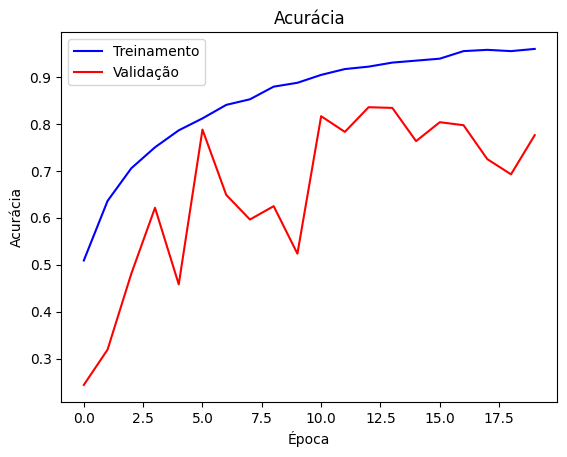

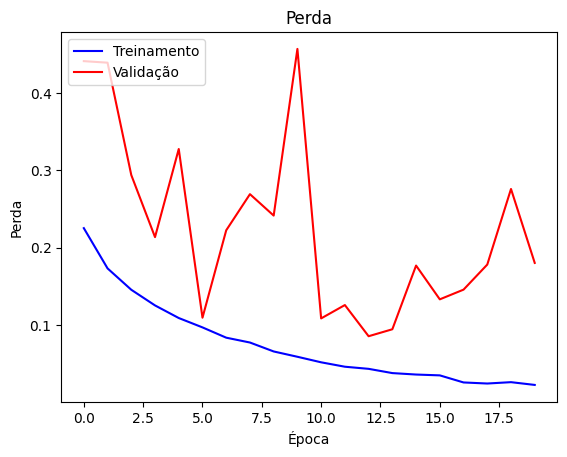

In [ ]:
historico = modelo_treino_base.history
acuracia_treino = historico['accuracy']
epocas_treino = historico['val_accuracy']
acuracia_perda = historico['loss']
acuracia_epocas = historico['val_loss']
mostrar_resultado_modelo("Modelo DenseNet Base", acuracia_treino, epocas_treino, acuracia_perda, acuracia_epocas)

----------------------------RESULTADO-MODELOS----------------------------

--Modelo DenseNet Gradiente--

Acurácias durante o treinamento:
['10.02%', '10.05%', '10.70%', '11.50%', '11.94%', '12.80%', '13.50%', '14.69%', '15.61%', '16.99%', '18.73%', '20.11%', '21.33%', '23.00%', '25.01%', '26.44%', '28.01%', '29.45%', '30.77%', '31.56%']

Perdas durante o treinamento:
['0.85', '0.80', '0.76', '0.73', '0.69', '0.66', '0.64', '0.61', '0.59', '0.57', '0.55', '0.53', '0.51', '0.49', '0.48', '0.47', '0.45', '0.44', '0.43', '0.42']




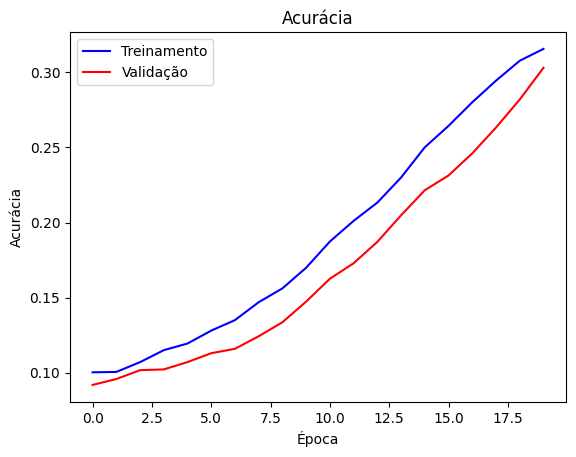

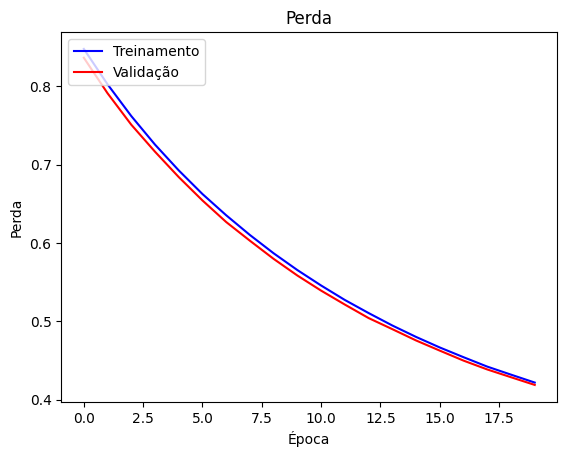

In [ ]:
historico = modelo_treino_gradiente.history
acuracia_treino = historico['accuracy']
epocas_treino = historico['val_accuracy']
acuracia_perda = historico['loss']
acuracia_epocas = historico['val_loss']
mostrar_resultado_modelo("Modelo DenseNet Gradiente", acuracia_treino, epocas_treino, acuracia_perda, acuracia_epocas)

----------------------------RESULTADO-MODELOS----------------------------

--Modelo DenseNet Adam--

Acurácias durante o treinamento:
['53.28%', '70.45%', '77.36%', '82.78%', '85.39%', '88.71%', '91.15%', '92.13%', '93.88%', '94.32%', '95.61%', '96.34%', '97.03%', '96.56%', '97.31%', '97.46%', '98.03%', '98.12%', '97.85%', '98.08%']

Perdas durante o treinamento:
['0.23', '0.15', '0.12', '0.09', '0.08', '0.06', '0.05', '0.04', '0.04', '0.03', '0.03', '0.02', '0.02', '0.02', '0.02', '0.02', '0.01', '0.01', '0.01', '0.01']




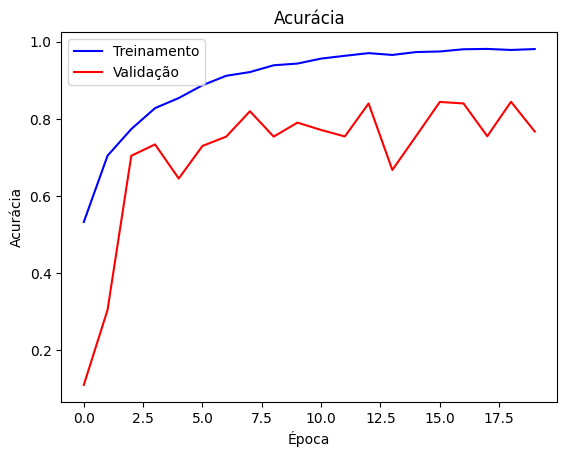

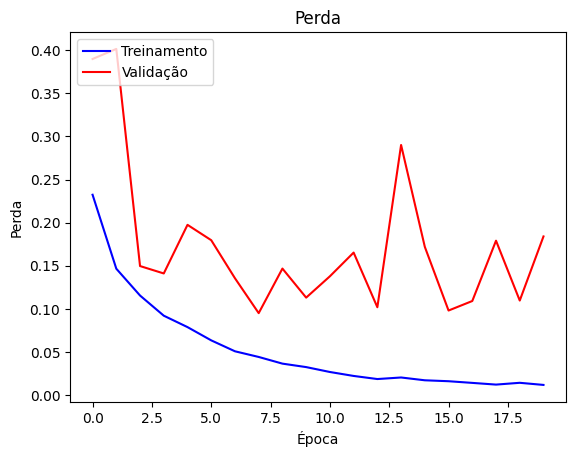

In [ ]:
historico = modelo_treino_adam.history
acuracia_treino = historico['accuracy']
epocas_treino = historico['val_accuracy']
acuracia_perda = historico['loss']
acuracia_epocas = historico['val_loss']
mostrar_resultado_modelo("Modelo DenseNet Adam", acuracia_treino, epocas_treino, acuracia_perda, acuracia_epocas)

In [ ]:
caminho_modelo = caminho_base + '/ModeloBaseDenseNet.h5'
classificador_densenet_base.save(caminho_modelo)

In [ ]:
caminho_modelo = caminho_base + '/ModeloGradienteDenseNet.h5'
classificador_densenet_gradiente.save(caminho_modelo)

In [ ]:
caminho_modelo = caminho_base + '/ModeloAdameDenseNet.h5'
classificador_densenet_adam.save(caminho_modelo)